In [62]:
print(["1 | 6 : Initializing libraries"])
import numpy as np
import ffmpeg
from matplotlib import cm
from matplotlib.pyplot import imshow
gray = cm.gray

filename="/Users/aspierer/Documents/Postdoc/Publications/PLoS_Genetics_flight/proof approval/figure_revisions/far_796_good_gif.gif"
filename="/Volumes/SPIERER/Flight/high_speed_videos/far_796_good_gif.gif"

interval = 20
method = "min"

['1 | 6 : Initializing libraries']


In [61]:

def video_to_array(file, **kwargs):
    '''Converts video into an nd-array using ffmpeg-python module.
    ----
    Inputs:
      file (str): Path to video file
      kwargs: Can be used with the ffmpeg.output() argument.
    ----
    Returns:
      image_stack (nd-array): nd-array of the video
    '''
    print(["2 | 6 : Reading input"])
    ## Extracting video meta-data
    try:
        try:
            probe = ffmpeg.probe(file)
        except:
            print('ERROR')
            raise SystemExit
        video_info = next(x for x in probe['streams'] if x['codec_type'] == 'video')
        width = int(video_info['width'])
        height = int(video_info['height'])
    except:
        print('!! Could not read in video file metadata')

    ## Converting video to nd-array    
    try:
        out,err = (ffmpeg
                   .input(file)
                   .output('pipe:',format='rawvideo', pix_fmt='rgb24',**kwargs)
                   .run(capture_stdout=True))
        n_frames = int(len(out)/height/width/3)
        image_stack = np.frombuffer(out, np.uint8).reshape([-1, height, width, 3])
    except:
        print('!! Could not read in video file to an array. Error message (if any):', err)

    return image_stack

stack = video_to_array(filename)
print(stack.shape)

['2 |  : Reading input']
(800, 1920, 1080, 3)


In [53]:
def get_interval(stack,n=1):
    '''Selects a stack of frames spaced some interval (n) apart
    ----
    Input:
    stack (ndarray): numpy array of images
    n (int): interval
    ----
    Returns:
    stack (ndarray): numpy array of images, but only includes every n-th frame
    '''
    print("3 | 6 : Slicing by designated interval {}".format(n))
    return stack[::n]
short_stack = get_interval(stack,interval)
short_stack.shape

3 |  : Slicing by designated interval 100


(8, 1920, 1080, 3)

In [54]:
def crop_and_grayscale(video_array,
                     x = 0 ,x_max = None,
                     y = 0 ,y_max = None,
                     first_frame = None,
                     last_frame = None,
                     grayscale = True):
    '''Crops imported video array to region of interest and converts it to grayscale
    ----
    Inputs:
      video_array (nd-array): image_stack generated from video_to_array function
      x (int): left-most x-position
      x_max (int): right-most x-position
      y (int): lowest y-position
      y_max (int): highest y-position
      first_frame (int): first frame to include
      last_frame (int): last frame to include
      grayscale (bool): True to convert to gray, False to leave in color. 
    ----
    Returns:
      clean_stack (nd-array): Cropped and grayscaled (if indicated) video as nd-array'''
    print("4 | 6 : Cropping frames and converting to grayscale")
    ## Conditionals for cropping frames and video length
    if first_frame == None: first_frame = 0
    if last_frame == None: last_frame = video_array.shape[0]
    if y_max == None: y_max = video_array.shape[1]
    if x_max == None: x_max = video_array.shape[2]

    ## Setting only frames and ROI to grayscale
    if grayscale:
        ch_1 = 0.2989 * video_array[first_frame:last_frame,y : y_max,x : x_max,0]
        ch_2 = 0.5870 * video_array[first_frame:last_frame,y : y_max,x : x_max,1]
        ch_3 = 0.1140 * video_array[first_frame:last_frame,y : y_max,x : x_max,2]
        clean_stack = ch_1.astype(float) + ch_2.astype(float) + ch_3.astype(float)

    ## Only cropping, no grayscaling
    else:
        clean_stack = video_array[first_frame:last_frame,y : y_max,x : x_max,:]
    return clean_stack

short_stack_gray = crop_and_grayscale(short_stack)
short_stack_gray.shape

4 |  : Cropping frames and converting to grayscale


(8, 1920, 1080)

In [57]:
def z_stack(stack, method = "min"):
    '''Create a z-stack from stack provided
    ----
    Input:
    stack (ndarray): numpy array of images
    ----
    Returns:
    stack (ndarray): '''
    print("5 | 6 : Flattening image stack using method:", method)    
    acceptable_args = ["min","max"]#,"stdev"]
    if method not in acceptable_args:
        print("ERROR! z-stack method must equal one: {}".format(acceptable_args))
    if method == "min":
        stack = np.amin(stack,axis=0)
    elif method == "max":
        stack = np.amax(stack,axis=0)
    return stack

z_short_stack_gray = z_stack(short_stack_gray, method = method)
z_short_stack_gray.shape

4 |  : Flattening image stack using method: min


(1920, 1080)

5 |  : Visualizing z-stack


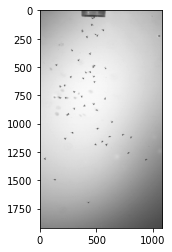

In [59]:
def visualize_stack(stack):
    print("6 | 6 : Visualizing z-stack")
    return imshow(stack,cmap=gray)

visualize_stack(z_short_stack_gray)

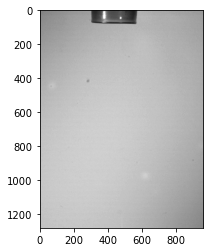

In [14]:
imshow(gray_stack[0], cmap=gray)

In [5]:
def subtract_background(video_array=None):
    '''Generate a null background image and subtract that from each frame
    ----
    Inputs:
      video_array (nd-array): clean_stack generated from crop_and_grayscale
      first_frame (int): First frame to consider for background subtraction
      last_frame (int): Last frame to consider for background subtraction
    ----
    Returns:
      spot_stack (nd-array): Background-subtracted image stack
      background (array): Array containing the pixel intensities for each x,y-coordinate'''

    ## Generating a null background image as the median pixel intensity across frames
    background = np.median(video_array[:,:,:].astype(float), axis=0).astype(int)

    ## Subtracting the null background image from each individual frame
    spot_stack = np.subtract(video_array,background)
    return spot_stack, background   
spot_stack,background = subtract_background(gray_stack)

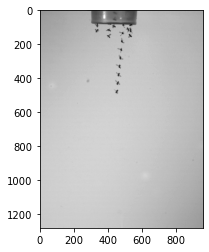

In [41]:
## Snippit for z-stack
imshow(np.amin(gray_stack[::10],axis=0),cmap=gray)


In [40]:
gray_stack.shape

(100, 1280, 960)